In [2]:
import os

import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

import sys
sys.path.append('..')

import modules.stats as st
import modules.plotting as pl
import modules.pandas_funcs as pf

In [3]:
results_dir = os.path.join('..', 'data', 'results')
match_dir = os.path.join('..', 'data', 'matching')


df_k_raw = pd.read_csv(os.path.join(results_dir, 'kinect_gait_metrics.csv'),
                       index_col=0)

df_z_raw = pd.read_csv(os.path.join(results_dir, 'zeno_gait_metrics.csv'),
                       index_col=0)

df_match = pd.read_csv(os.path.join(match_dir, 'match_kinect_zeno.csv'))

# Drop rows where file has no match
df_match = df_match.dropna(axis=0)


df_match_zeno = pd.merge(df_match, df_z_raw, left_on='Zeno', right_index=True)

df_total = pd.merge(df_match_zeno, df_k_raw, left_on='Kinect',
                    right_index=True, suffixes=('_z', '_k'))


# Take columns from total DataFrame to get Kinect and Zeno data
df_k = df_total.filter(like='_k')
df_z = df_total.filter(like='_z')

# Remove suffixes from column names
df_k = df_k.rename(columns=lambda x: str(x)[:-2])
df_z = df_z.rename(columns=lambda x: str(x)[:-2])

# Group by gait metric without suffix
df_k_grouped = df_k.groupby(lambda x: x[:-2], axis=1).mean()
df_z_grouped = df_z.groupby(lambda x: x[:-2], axis=1).mean()

## Visual Results

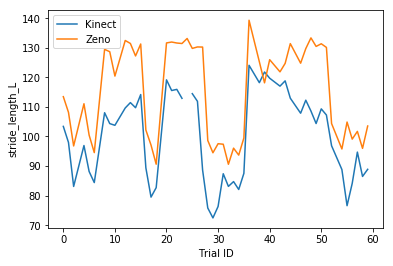

In [4]:
%matplotlib inline

metric = 'stride_length_L'

plt.plot(df_k[metric])
plt.plot(df_z[metric])

plt.xlabel('Trial ID')
plt.ylabel(metric)

plt.legend(['Kinect', 'Zeno'])
plt.show()

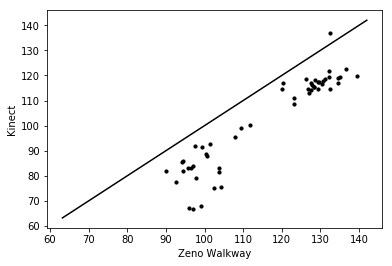

In [23]:
x_label, y_label = 'Zeno Walkway', 'Kinect'
metric = 'stride_length_R'
    
pl.compare_measurements(df_z[metric], df_k[metric], c='k', s=10)

plt.xlabel(x_label)
plt.ylabel(y_label)
plt.show()

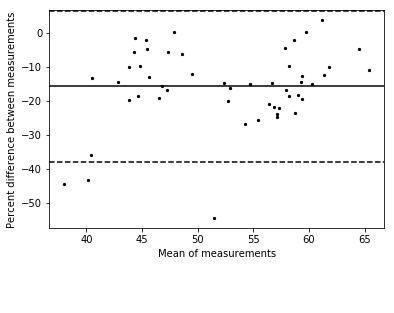

In [6]:
metric = 'step_length_L'

# Bland-Altman object
bland_obj = st.BlandAltman(df_k[metric], df_z[metric], percent=True)

pl.plot_bland_altman(bland_obj.means, bland_obj.differences, bland_obj.bias, 
                     bland_obj.limits_of_agreement, percent=True)

## Quantitative Results

In [7]:
funcs = {'Pearson': lambda a, b: pearsonr(a, b)[0],
        'Spearman': lambda a, b: spearmanr(a, b)[0],
        'Abs rel error': lambda a, b: st.relative_error(a, b, absolute=True).mean(),
        'Bias': lambda a, b: st.BlandAltman(a, b).bias, 
        'Range': lambda a, b: st.BlandAltman(a, b).range}
 
    
d = {name: pf.apply_to_columns(df_k, df_z, func) for name, func in funcs.items()}

df_results = pd.DataFrame(d).T
df_results

,step_length_L,step_length_R,stride_length_L,stride_length_R,stride_time_L,stride_time_R,stride_velocity_L,stride_velocity_R,stride_width_L,stride_width_R
Pearson,0.752159,0.882861,0.882382,0.934844,0.893862,0.828876,0.932593,0.957129,0.765060,0.815263
Spearman,0.730226,0.866388,0.804163,0.890653,0.652882,0.606439,0.811584,0.843507,0.716380,0.767267
Abs rel error,0.142366,0.155019,0.133206,0.124803,0.186377,0.194353,0.096851,0.097932,4.584911,5.507370
Bias,-0.156940,-0.173295,-0.143538,-0.134492,-0.210046,-0.221308,0.058645,0.077822,0.829137,0.775716
Range,0.444094,0.447536,0.275999,0.320604,0.397478,0.468866,0.387307,0.341335,5.124523,4.422817


In [8]:
d = {name: pf.apply_to_columns(df_k_grouped, df_z_grouped, func) for name, func in funcs.items()}

df_grouped = pd.DataFrame(d).T
df_grouped

,step_length,stride_length,stride_time,stride_velocity,stride_width
Pearson,0.896675,0.935782,0.876337,0.951590,0.825364
Spearman,0.846837,0.850849,0.659914,0.829079,0.774695
Abs rel error,0.148486,0.127329,0.190911,0.096635,2.527762
Bias,-0.163400,-0.137740,-0.215611,0.069792,0.801871
Range,0.331570,0.252376,0.401060,0.337098,4.728945


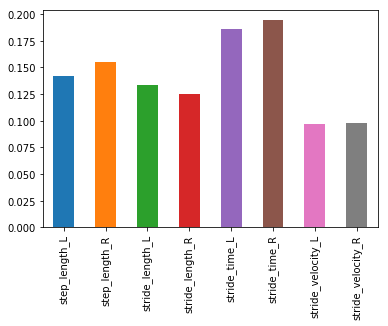

In [9]:
df_results.loc['Abs rel error'][:-2].plot.bar()

In [10]:
df_sides = df_results.groupby(lambda x: x.split('_')[-1], axis=1).mean()
df_sides

,L,R
Pearson,0.845211,0.883795
Spearman,0.743047,0.794851
Abs rel error,1.028742,1.215896
Bias,0.075452,0.064889
Range,1.325880,1.200232


In [11]:
df_grouped.stride_length * 100

Pearson          93.578248
Spearman         85.084948
Abs rel error    12.732869
Bias            -13.774015
Range            25.237589
Name: stride_length, dtype: float64

In [12]:
df = abs(df_k - df_z) / df_z * 100

In [13]:
max_idx = df.stride_length_L.idxmax()

In [14]:
df_k.loc[max_idx]

step_length_L         37.503645
step_length_R         52.838454
stride_length_L       88.640372
stride_length_R      115.256369
stride_time_L          0.766667
stride_time_R          0.991667
stride_velocity_L    115.523807
stride_velocity_R    116.561491
stride_width_L         7.983391
stride_width_R         9.031434
Name: 27, dtype: float64

In [15]:
df_z.loc[max_idx]

step_length_L         65.494
step_length_R         64.296
stride_length_L      130.235
stride_length_R      128.386
stride_time_L          1.159
stride_time_R          1.174
stride_velocity_L    112.486
stride_velocity_R    109.421
stride_width_L         0.262
stride_width_R         1.656
Name: 27, dtype: float64

In [16]:
df_match.loc[max_idx]

Zeno      B_2014-12-16_P005_Pre_tc_dtabc
Kinect           2014-12-16_P005_Pre_002
Name: 27, dtype: object